# PARCtorch

This example demonstrates how to train a PARC model for the Burgers equation. 
- Download the data from https://zenodo.org/records/13909869 and unzip it.
- It assumes that the data is stored in the data/burgers directory. Make sure to update the `train_dir` and `test_dir` below to point to the correct location.
- Install PARCtorch in the current python environment.


## Normalization

In [19]:
from pathlib import Path
from PARCtorch.data.normalization import compute_min_max

In [ ]:
# Define data directories
train_dir = Path("./data/burgers/train")
test_dir = Path("./data/burgers/test")
min_max_file = train_dir.parent / "b_min_max.json"

compute_min_max([train_dir, test_dir], min_max_file)

## Create Data Loader for Training

In [ ]:
import logging
import torch
from torch.utils.data import DataLoader

# Now import the utilities
from PARCtorch.data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from PARCtorch.utilities.viz import (
    visualize_channels,
    save_gifs_with_ground_truth,
)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

future_steps = 1
# Path to the min_max.json file
batch_size = 4

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[train_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

## Visualize the Data was Loaded Properly

Channel Data Statistics:
Channel 0: IC min=0.6644295454025269, IC max=0.6644295454025269
  Step 1: min=0.6644295454025269, max=0.6644295454025269
Channel 1: IC min=7.64794982899275e-09, IC max=0.4998920261859894
  Step 1: min=7.64794982899275e-09, max=0.49605339765548706
Channel 2: IC min=7.64794982899275e-09, IC max=0.4998920261859894
  Step 1: min=7.64794982899275e-09, max=0.49605339765548706


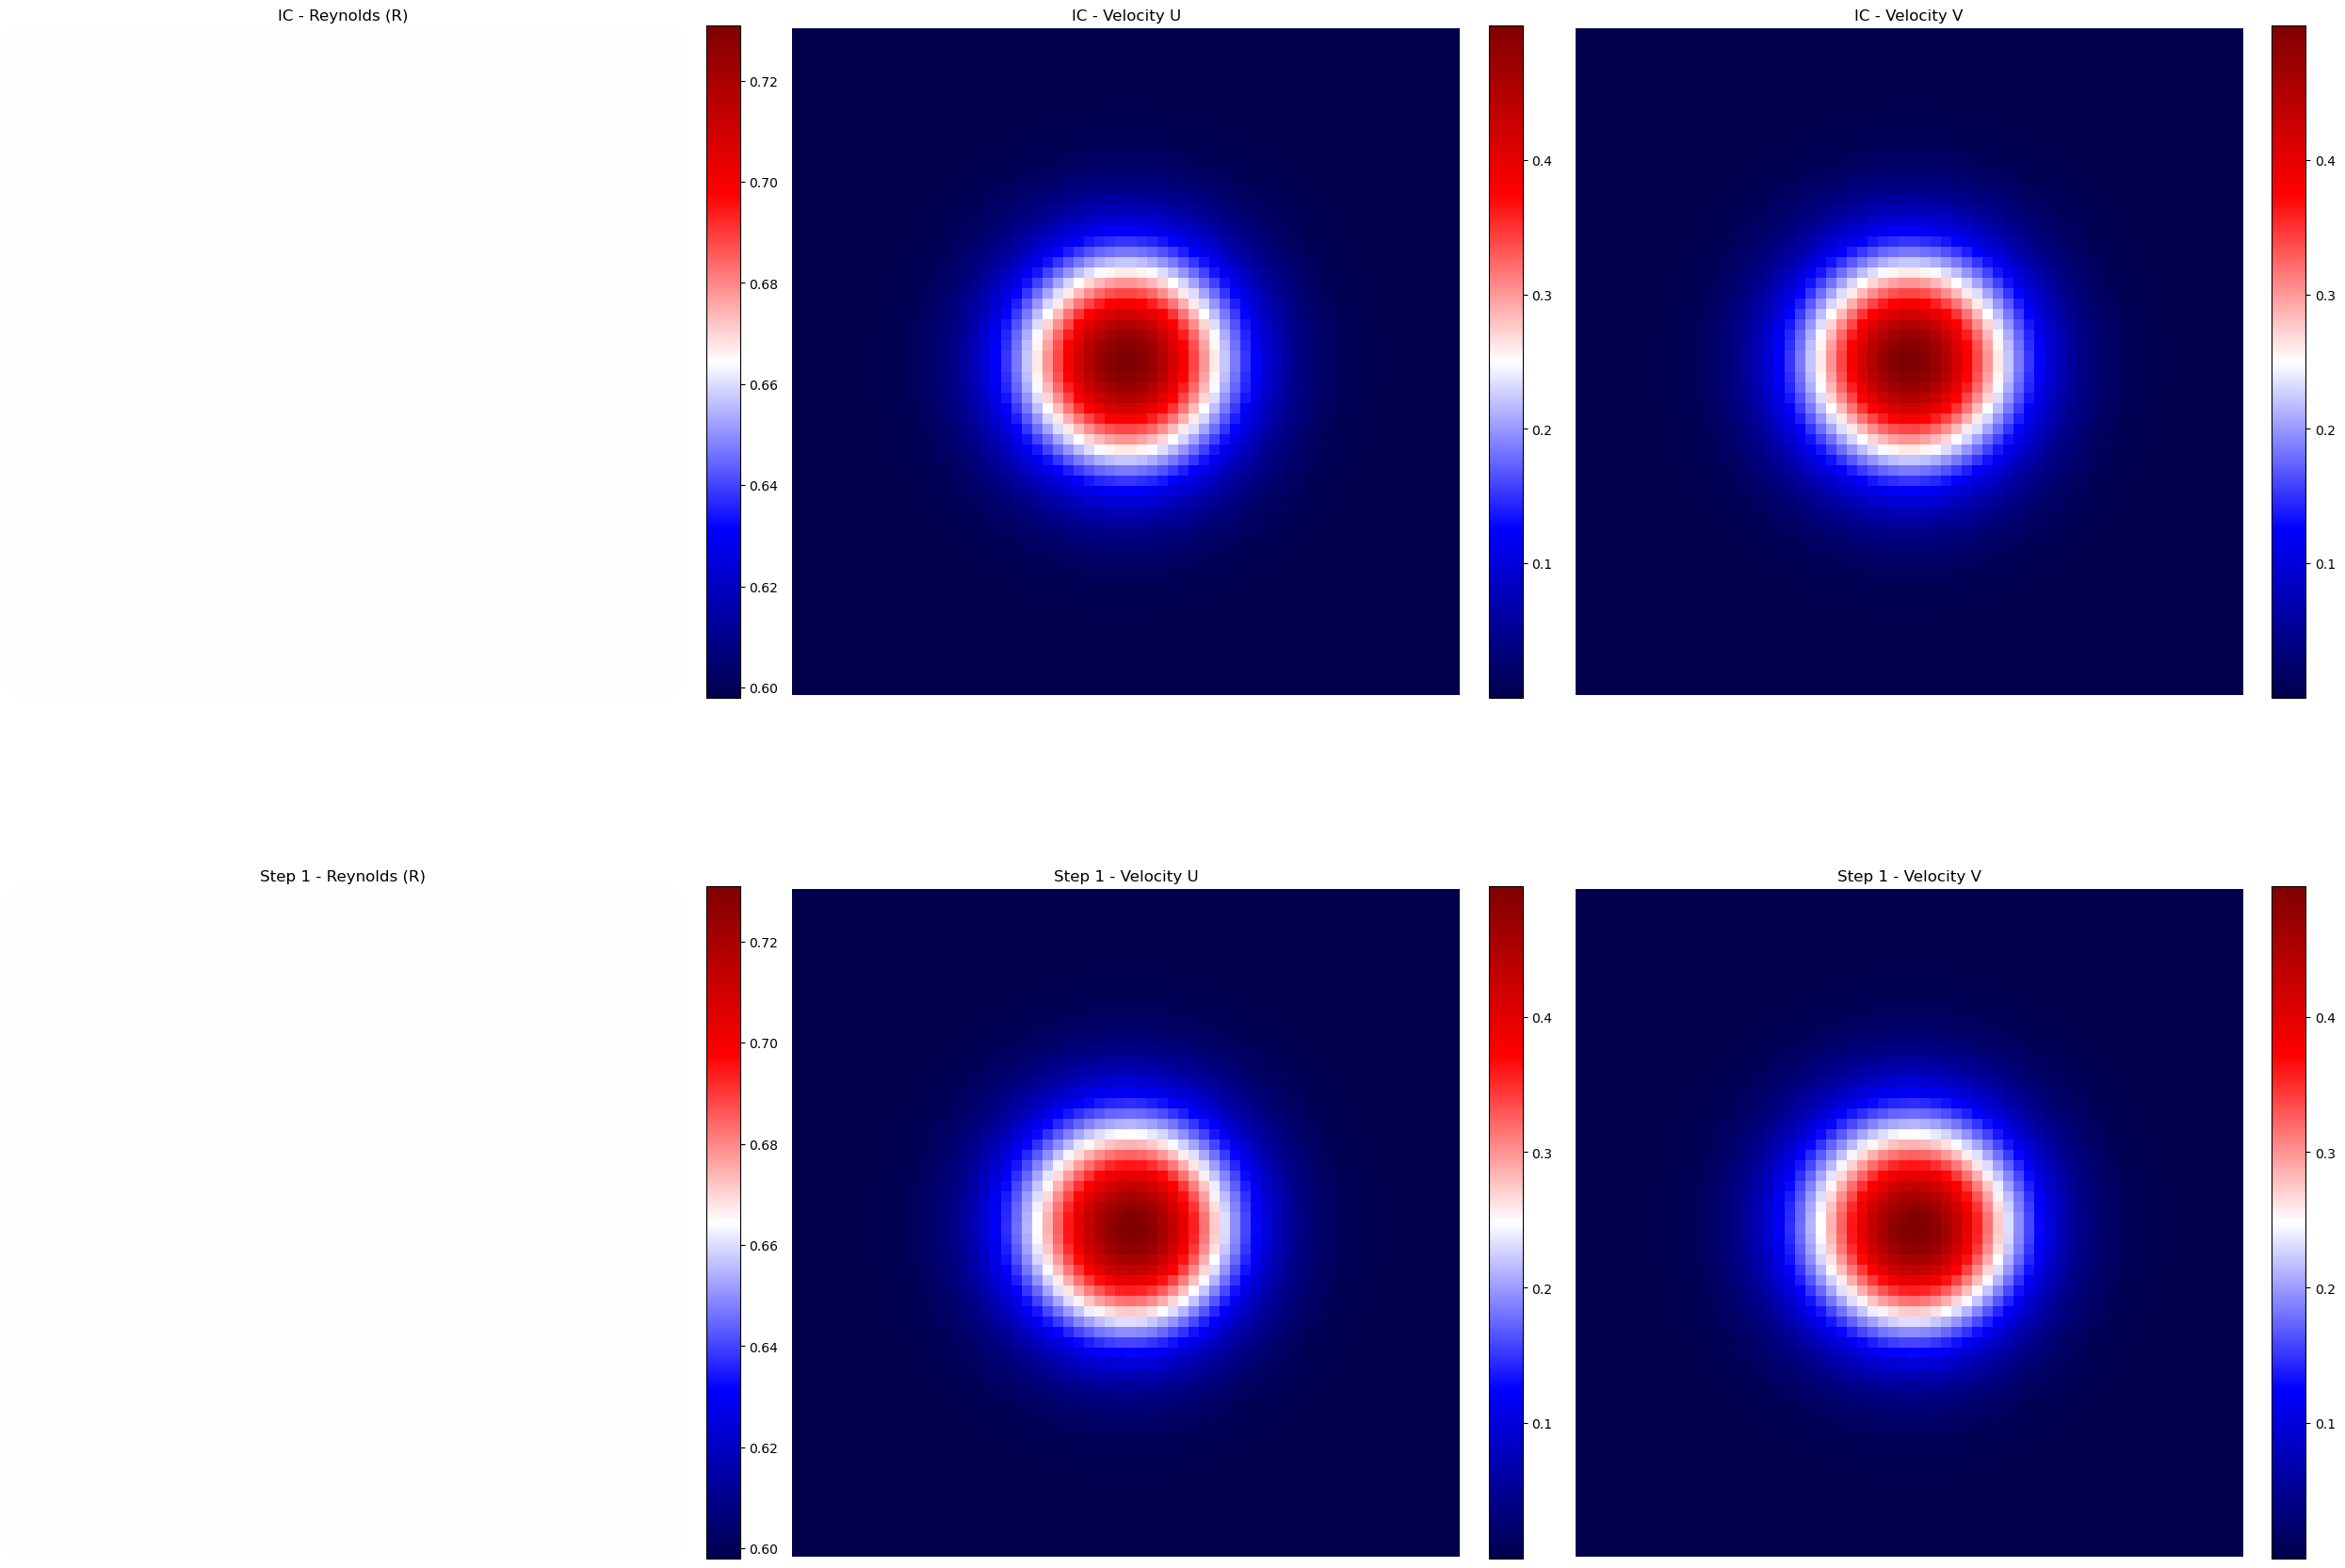

In [22]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = ["Reynolds (R)", "Velocity U", "Velocity V"]
    custom_cmaps = ["seismic", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

## Build your PARC Model

In [23]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import ADRDifferentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

from torch.optim import Adam

In [24]:
# Navier Stokes: p, re, u, v
# Adv: u, v
# Dif: u, v
# Poi: p
n_fe_features = 64
unet_burgers = UNet(
    [64, 64 * 2, 64 * 4],
    3,
    n_fe_features,
    up_block_use_concat=[False, True],
    skip_connection_indices=[0],
)
right_diff = FiniteDifference(padding_mode="replicate").cuda()
heun_int = Heun().cuda()
diff_burgers = ADRDifferentiator(
    1,  # 1 state variables: re. We always assume 2 velocity being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network: 64
    [1, 2],  # Channel indices to calculate advection: u and v
    [1, 2],  # Channel indices to calculate diffusion: u and v
    unet_burgers,  # Feature extraction network: unet_burgers
    "constant",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replication of image_gradients
    False,
).cuda()
burgers_int = Integrator(
    True, [], heun_int, [None, None, None], "constant", right_diff
)
criterion = torch.nn.L1Loss().cuda()
model = PARCv2(diff_burgers, burgers_int, criterion).cuda()
optimizer = Adam(model.parameters(), lr=1e-5)

## Train the Model 

In [ ]:
from train import train_model

# Example usage:
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=1,
    save_dir=train_dir.parent,
    app="burgers",
)

## Load the Model

In [ ]:
from utilities.load import load_model_weights

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = train_dir.parent / "model.pth"  # Replace with your path
model = load_model_weights(model, model_weights_path, device)

## Create the Sequence DataLoader
### This will contain the t=0 for each test file

In [ ]:
# Initialize the dataset
future_steps = 3
seq_dataset = InitialConditionDataset(
    data_dirs=[test_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

## Ground Truth Loader

In [ ]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[test_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

## Visualize the Results

In [ ]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["Reynolds", "u", "v"]  # Adjust as per your data
cmaps = ["plasma", "inferno", "magma"]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset